In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import os
from IPython.display import clear_output
import requests

# Для оценки без меток
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# 1. Загрузка данных

In [ ]:
# Загрузка данных из репозитория
data_folder_url = "https://github.com/waico/SKAB/raw/master/data/valve1/"
data_folder_path = "data/valve1/"

if not os.path.exists(data_folder_path):
    os.makedirs(data_folder_path, exist_ok=True)
    for i in range(1, 11):  # Загрузка нескольких файлов
        file_name = f"{i}.csv"
        response = requests.get(data_folder_url + file_name)
        with open(data_folder_path + file_name, "wb") as f:
            f.write(response.content)

# Чтение и объединение всех CSV файлов
csv_files = glob.glob(data_folder_path + "*.csv")
data_frames = [pd.read_csv(file, delimiter=';') for file in csv_files]
data = pd.concat(data_frames, ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11303 entries, 0 to 11302
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             11303 non-null  object 
 1   Accelerometer1RMS    11303 non-null  float64
 2   Accelerometer2RMS    11303 non-null  float64
 3   Current              11303 non-null  float64
 4   Pressure             11303 non-null  float64
 5   Temperature          11303 non-null  float64
 6   Thermocouple         11303 non-null  float64
 7   Voltage              11303 non-null  float64
 8   Volume Flow RateRMS  11303 non-null  float64
 9   anomaly              11303 non-null  float64
 10  changepoint          11303 non-null  float64
dtypes: float64(10), object(1)
memory usage: 971.5+ KB


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [ ]:
data.index = data['datetime']
data.drop(columns=['datetime'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11303 entries, 2020-03-09 12:54:39 to 2020-03-09 13:54:38
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    11303 non-null  float64
 1   Accelerometer2RMS    11303 non-null  float64
 2   Current              11303 non-null  float64
 3   Pressure             11303 non-null  float64
 4   Temperature          11303 non-null  float64
 5   Thermocouple         11303 non-null  float64
 6   Voltage              11303 non-null  float64
 7   Volume Flow RateRMS  11303 non-null  float64
 8   anomaly              11303 non-null  float64
 9   changepoint          11303 non-null  float64
dtypes: float64(10)
memory usage: 971.4 KB


In [ ]:
values = data.drop(columns=['anomaly'])
target = data['anomaly'].values if 'anomaly' in data.columns else None

In [ ]:
# Разделение данных на train/test
train_size = int(0.8 * len(values))
train_values = values[:train_size]
test_values = values[train_size:]

if target is not None:
    train_target = target[:train_size]
    test_target = target[train_size:]
else:
    train_target, test_target = None, None


У нас есть таргеты, т.е. рассматриваем supervised задачу.

# 2. Proximity-based методы,

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
pred_lof = lof.fit_predict(train_values)
pred_lof_test = lof.fit_predict(test_values)
pred_lof_test = (pred_lof_test == -1).astype(int)

# 3. Prediction-based: Линейная регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

if train_target is not None:
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(train_values, train_target)
    pred_lr = logistic_model.predict(test_values)
else:
    pred_lr = np.zeros(len(test_values))  # Если меток нет, используем заглушку

# 4. Reconstruction-based

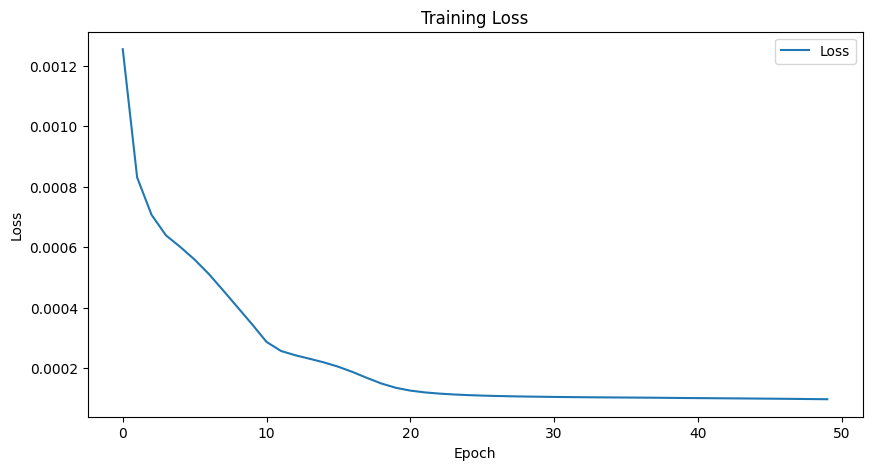

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Нормализация данных
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)
train_scaled = scaled_values[:train_size]
test_scaled = scaled_values[train_size:]

# Преобразование данных в тензоры
train_tensor = torch.tensor(train_scaled, dtype=torch.float32)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32)

# Инициализация автоэнкодера
input_dim = scaled_values.shape[1]
autoencoder = Autoencoder(input_dim)

# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Обучение автоэнкодера
num_epochs = 50
batch_size = 32
losses = []
for epoch in range(num_epochs):
    autoencoder.train()
    epoch_loss = 0
    for i in range(0, len(train_tensor), batch_size):
        batch = train_tensor[i:i + batch_size]
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_tensor))

    # Обновление графика потерь
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

# Ошибка реконструкции
autoencoder.eval()
with torch.no_grad():
    reconstruction = autoencoder(test_tensor).numpy()

mse = np.mean(np.square(test_scaled - reconstruction), axis=1)
threshold_ae = np.percentile(mse, 95)
pred_ae = (mse > threshold_ae).astype(int)

# 5. Рассчет метрик

In [ ]:
# Расчет метрик
if test_target is not None:
    metrics = {}
    for method, pred in zip(["LOF", "Logistic Regression", "Autoencoder"], [pred_lof_test, pred_lr, pred_ae]):
        metrics[method] = {
            "F1": f1_score(test_target, pred),
            "Precision": precision_score(test_target, pred),
            "Recall": recall_score(test_target, pred)
        }

    # Вывод метрик
    for method, scores in metrics.items():
        print(f"Метрики для {method}: {scores}")

Метрики для LOF: {'F1': 0.17156286721504113, 'Precision': 0.6460176991150443, 'Recall': 0.0989159891598916}
Метрики для Logistic Regression: {'F1': 0.7762430939226519, 'Precision': 0.7915492957746478, 'Recall': 0.7615176151761518}
Метрики для Autoencoder: {'F1': 0.18801410105757932, 'Precision': 0.7079646017699115, 'Recall': 0.10840108401084012}


# 6. Оценка предсказаний модели в предположении, что релаьные значения таргета неизвестны.

In [ ]:
# Оценка качества моделей без использования таргета (без лейблов)
# Для LOF у нас есть исходные скоры аномалий (negative_outlier_factor_)
lof_full = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_full.fit(values)
lof_scores = -lof_full.negative_outlier_factor_[train_size:]  # чем больше, тем более аномально
lof_anom_scores = lof_scores[pred_lof_test == 1]
lof_norm_scores = lof_scores[pred_lof_test == 0]
if len(lof_anom_scores) > 0 and len(lof_norm_scores) > 0:
    lof_ratio = lof_anom_scores.mean() / lof_norm_scores.mean()
    print("LOF среднее отношение аномального скора к нормальному (без меток):", lof_ratio)
    sil_lof = silhouette_score(test_values, pred_lof_test) if len(np.unique(pred_lof_test)) > 1 else np.nan
    print("LOF Silhouette score (без меток):", sil_lof)

LOF среднее отношение аномального скора к нормальному (без меток): 1.2993401453337114
LOF Silhouette score (без меток): 0.0760208211583974


In [ ]:
# Для автоэнкодера используем ошибки реконструкции как скор
ae_anom_scores = mse[pred_ae == 1]
ae_norm_scores = mse[pred_ae == 0]
if len(ae_anom_scores) > 0 and len(ae_norm_scores) > 0:
    ae_ratio = ae_anom_scores.mean() / ae_norm_scores.mean()
    print("AE среднее отношение ошибки реконструкции для аномалий к норме (без меток):", ae_ratio)
    sil_ae = silhouette_score(test_values, pred_ae) if len(np.unique(pred_ae)) > 1 else np.nan
    print("AE Silhouette score (без меток):", sil_ae)


AE среднее отношение ошибки реконструкции для аномалий к норме (без меток): 4.151329562059856
AE Silhouette score (без меток): 0.040540088164813526


In [ ]:
# Для логистической регрессии без меток мы не можем посчитать F1 или др.
# Однако можно оценить различие в распределении значений между предсказанными аномалиями и нормой
lr_anom_values = test_values[pred_lr == 1]
lr_norm_values = test_values[pred_lr == 0]
if len(lr_anom_values) > 0 and len(lr_norm_values) > 0:
    mean_diff_lr = lr_anom_values.mean() - lr_norm_values.mean()
    print("LR средняя разница значений аномалия-норма (без меток):", mean_diff_lr)
    sil_lr = silhouette_score(test_values, pred_lr) if len(np.unique(pred_lr)) > 1 else np.nan
    print("LR Silhouette score (без меток):", sil_lr)

LR средняя разница значений аномалия-норма (без меток): Accelerometer1RMS      0.000020
Accelerometer2RMS      0.000719
Current               -0.002026
Pressure               0.003603
Temperature           -0.511941
Thermocouple           0.029944
Voltage               -0.922127
Volume Flow RateRMS   -1.687470
changepoint            0.003700
dtype: float64
LR Silhouette score (без меток): 0.01773198247578626


Лучшее значение скора - 1, отсюда видно, что модели справились не очень хорошо. При этом самый ниский скор у логистической регресии, которая лучше всех предсказывает аномалии с точки зрения f1. Это лишь подтверждает, что unsupervised оценки могут работать очень неточно.